<a href="https://colab.research.google.com/github/sbhumi/490TermProject/blob/main/Transfer_Learning_Kaggle_to_OASIS3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Installing nibabel
!pip install nibabel

# Importing
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, Sequential
from keras.layers import *
import matplotlib.pyplot as plt
from matplotlib import image
import os
import nibabel as nib
import pandas as pd
import scipy
from scipy import ndimage
from PIL import Image
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')
from keras import Model 
from tensorflow.keras.optimizers import Adam
from keras import callbacks

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing old model for transfer learning

In [ ]:
T1000 = keras.models.load_model('/content/drive/MyDrive/Kaggle Alzheimer\'s Dataset/new_model.h5')

In [ ]:
T1000.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_22 (Conv2D)          (None, 126, 126, 64)      640       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 63, 63, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 61, 61, 128)       73856     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 30, 30, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 28, 28, 256)       295168

# Freezing Old Model

In [ ]:
T1000.trainable = False

# Slicing Old Model after the Flattening layer and adding a new Dense layer to be trained on the new data

In [ ]:
newLayer = Dense(128, activation = 'relu')(T1000.layers[7].output) #new hidden layer
newLayer = Dense(1, activation = 'sigmoid')(newLayer) #new output layer
T5000 = Model(T1000.input, newLayer)
T5000.compile(optimizer = Adam(), loss = 'binary_crossentropy', metrics = ['acc'])
T5000.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_22 (Conv2D)          (None, 126, 126, 64)      640       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 63, 63, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 61, 61, 128)       73856     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 30, 30, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 28, 28, 256)       295168

In [ ]:
# making sure everything is frozen correctly
for layers in T5000.layers:
    print(layers.trainable)

False
False
False
False
False
False
False
False
True
True


# Reading in the new dataset positive classes

In [ ]:
!unzip '/content/drive/MyDrive/Alzheimers Model/adSlices.npz' -d '/content/adSlices.npy'

Archive:  /content/drive/MyDrive/Alzheimers Model/adSlices.npz
  inflating: /content/adSlices.npy/arr_0.npy  


# Creating an array of all 1's to indicate positive diagnosis

In [ ]:
aPositive = np.load('/content/adSlices.npy/arr_0.npy') # array of positive patients scans
aPositiveLabels = np.ones((aPositive.shape[0],)) # creating lables for positive patients

In [ ]:
print(aPositive.shape)
print(aPositiveLabels.shape)

(170, 128, 128, 1)
(170,)


# Reading in the new dataset negative classes

In [ ]:
!unzip '/content/drive/MyDrive/Alzheimers Model/nonSlices.npz' -d '/content/adNegative.npy'

Archive:  /content/drive/MyDrive/Alzheimers Model/nonSlices.npz
  inflating: /content/adNegative.npy/arr_0.npy  


# Creating an array of all 0's to indicate a negative diagnosis

In [ ]:
aNegative = np.load('/content/adNegative.npy/arr_0.npy') # array of negative patients' scans
aNegativeLabels = np.zeros((aNegative.shape[0],)) # creating labels for negative patients

In [ ]:
print(aNegative.shape)
print(aNegativeLabels.shape)

(171, 128, 128, 1)
(171,)


# Combining the Positive and Negative datasets

In [ ]:
data = np.concatenate([aNegative, aPositive], axis = 0)
targets = np.concatenate([aNegativeLabels, aPositiveLabels], axis = 0)
print(data.shape)
print(targets.shape)

(341, 128, 128, 1)
(341,)


# defining function to shuffle the dataset and labels together

In [ ]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

# Shuffling the dataset

In [ ]:
data, targets = unison_shuffled_copies(data, targets)

# Splitting the validation data from the training data

In [ ]:
data_validate = data[-30:]
targets_validate = targets[-30:]
data = data[:-30]
targets = targets[:-30]

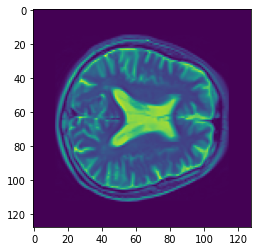

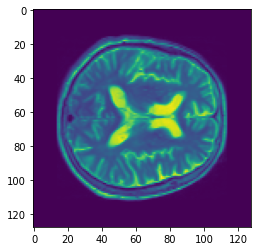

In [ ]:
plt.imshow(data[0].reshape(128,128))
plt.show()
plt.imshow(data[1].reshape(128,128))
plt.show()

# Defining Callbacks

In [ ]:
stop = callbacks.EarlyStopping(patience = 5, restore_best_weights= True)
rlr = callbacks.ReduceLROnPlateau(patience = 3)
check = callbacks.ModelCheckpoint('/content/drive/MyDrive/Alzheimers Model/checkpointT5000.h5')

# Training the model on the new data with a validation split of .10 batch size of 10 (because the new dataset is so small, IE perfect to use transfer learning on) 

In [ ]:
history1 = T5000.fit(data, targets, validation_split= .10, epochs = 20, batch_size = 10 ,callbacks= [stop, rlr, check])

Epoch 1/20
28/28 [==============================] - 1s 40ms/step - loss: 1.6710e-17 - acc: 1.0000 - val_loss: 1.4577e-24 - val_acc: 1.0000 - lr: 1.0000e-06
Epoch 2/20
28/28 [==============================] - 0s 14ms/step - loss: 1.6710e-17 - acc: 1.0000 - val_loss: 1.4577e-24 - val_acc: 1.0000 - lr: 1.0000e-06
Epoch 3/20
28/28 [==============================] - 0s 13ms/step - loss: 1.6710e-17 - acc: 1.0000 - val_loss: 1.4577e-24 - val_acc: 1.0000 - lr: 1.0000e-06
Epoch 4/20
28/28 [==============================] - 0s 15ms/step - loss: 1.6710e-17 - acc: 1.0000 - val_loss: 1.4577e-24 - val_acc: 1.0000 - lr: 1.0000e-06
Epoch 5/20
28/28 [==============================] - 0s 14ms/step - loss: 1.6710e-17 - acc: 1.0000 - val_loss: 1.4577e-24 - val_acc: 1.0000 - lr: 1.0000e-07
Epoch 6/20
28/28 [==============================] - 0s 13ms/step - loss: 1.6710e-17 - acc: 1.0000 - val_loss: 1.4577e-24 - val_acc: 1.0000 - lr: 1.0000e-07


# Testing on the validation data

In [ ]:
T5000.evaluate(data_validate, targets_validate)

1/1 [==============================] - 0s 73ms/step - loss: 7.4826e-15 - acc: 1.0000


[7.482604352749764e-15, 1.0]

# Reading in a little more validation data for extra assurance of correctness

In [ ]:
non = np.load('/content/drive/MyDrive/Alzheimers Model/nonValidation.npy')
ada = np.load('/content/drive/MyDrive/Alzheimers Model/adValidation.npy')

In [ ]:
ada.shape

(20, 128, 128, 1)

In [ ]:
z = T5000.predict(non)

# This dataset was of all positive diagnosis and the predictions all classify these images as positive P = 1

In [ ]:
z

array([[1.0000000e+00],
       [9.9979192e-01],
       [5.8000383e-05],
       [1.6463010e-12],
       [6.8966739e-20],
       [3.6087347e-27],
       [5.3501696e-29],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [5.9605318e-38],
       [6.4397181e-36],
       [2.7171126e-36],
       [2.8823692e-38],
       [5.1752995e-24],
       [9.0262684e-28],
       [2.6156454e-35]], dtype=float32)

# This was a dataset consisting of all negative results, as you can see it classified everything as negative: P(predicton) = 0, (save the first 3 images).

In [ ]:
q = T5000.predict(ada)
q.round(5)

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

# Saving Model 

In [ ]:
T5000.save('/content/drive/MyDrive/Alzheimers Model/T5000.h5')